### Etude du risque du marché

In [470]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.dates as dates

In [144]:
sns.set_theme(style='darkgrid')

In [100]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [334]:
data_excel = pd.read_excel('SW_data/environment.xlsx', parse_dates=True)
data_excel.head()

,ISIN,Date,Quote
0,SLFXFSI2 Index,1996-01-05,-0.459
1,SLFXFSI2 Index,1996-01-12,-0.197
2,SLFXFSI2 Index,1996-01-19,-0.190
3,SLFXFSI2 Index,1996-01-26,-0.412
4,SLFXFSI2 Index,1996-02-02,-0.404


In [335]:
tickers = list(data_excel.ISIN.unique())
print('Tickers : \n')
print('\n'.join(map(str, tickers))) 

Tickers : 

SLFXFSI2 Index
VIX Index
BICLB10Y Index
SPXT Index


In [401]:
data = data_excel.pivot(columns='ISIN', index='Date').fillna(method='ffill', limit=7).dropna()
data.columns = data.columns.droplevel()
data = data.drop(columns=['BICLB10Y Index'])
data.columns = ['Stress', 'SP500', 'VIX']
data.index.name = 'Date'
data.columns.name = None
data.head(5)

,Stress,SP500,VIX
Date,,,
1996-01-05,-0.459,793.20,13.58
1996-01-08,-0.459,795.68,13.11
1996-01-09,-0.459,784.16,15.21
1996-01-10,-0.459,770.11,16.40
1996-01-11,-0.459,775.56,14.69


In [403]:
# Ajout de la donnée sur les HY Spread
spread_excel = pd.read_excel('SW_data/spread.xlsx', parse_dates=True, index_col=1).drop(columns=['ISIN']).rename(columns={'Quote': 'HY Spread'})
spread_excel = spread_excel.reindex(data.index, method='ffill')
spread_excel.head(2)

,HY Spread
Date,
1996-01-05,3.84
1996-01-08,3.84


In [404]:
data['Spread'] = spread_excel.values
data.head(2)

,Stress,SP500,VIX,Spread
Date,,,,
1996-01-05,-0.459,793.20,13.58,3.84
1996-01-08,-0.459,795.68,13.11,3.84


In [400]:
# Décalage d'une semaine l'indice de Stress
data_stress = data_excel[data_excel.ISIN == 'SLFXFSI2 Index']
data_stress.index = data_stress.Date
data_stress = data_stress[['Quote']]
data_stress = data_stress.shift(1)
data_stress = data_stress.reindex(data.index, method='ffill')
data.Stress = data_stress.values
data.head(20)

,Stress,SP500,VIX,Spread
Date,,,,
1996-01-05,NaN,793.20,13.58,3.84
1996-01-08,NaN,795.68,13.11,3.84
1996-01-09,NaN,784.16,15.21,3.84
1996-01-10,NaN,770.11,16.40,3.84
1996-01-11,NaN,775.56,14.69,3.84
1996-01-12,-0.459,774.43,14.23,3.84
1996-01-15,-0.459,771.87,14.99,3.84
1996-01-16,-0.459,782.97,14.09,3.84
1996-01-17,-0.459,780.37,14.25,3.84


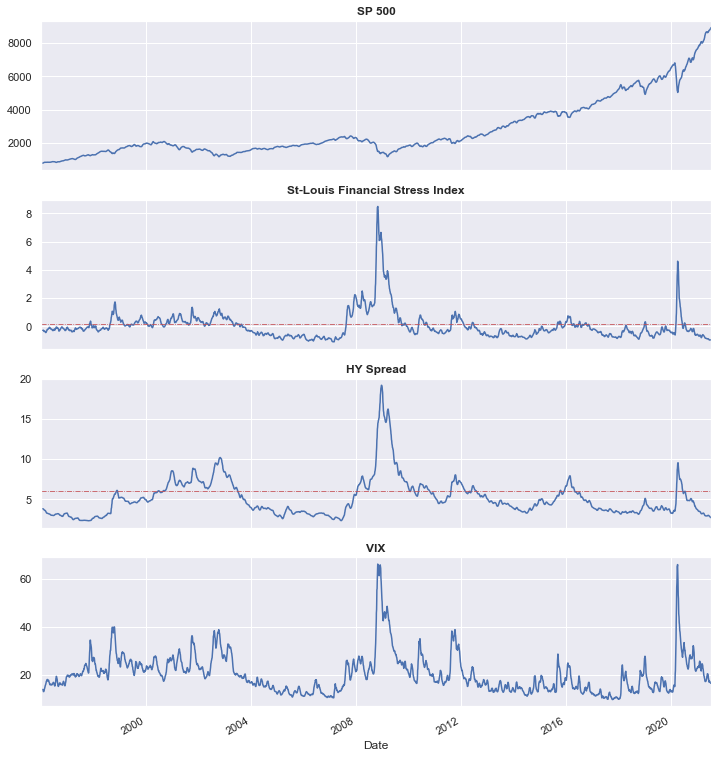

In [467]:
fig, axs = plt.subplots(4, 1, figsize=(12,14), sharex=True)
data.SP500.rolling(15).mean().plot(ax=axs[0], label='SP500')
axs[0].set_title('SP 500', fontweight='bold')
axs[0].set_xlim(data.index[0], data.index[-1])
axs[0].grid(b=True)

data.Stress.rolling(15).mean().plot(ax=axs[1])
axs[1].set_title('St-Louis Financial Stress Index', fontweight='bold')
axs[1].axhline(y=0.2, linestyle='-.', c='r', lw=0.8)
axs[1].grid(b=True)

data.Spread.rolling(15).mean().plot(ax=axs[2])
axs[2].set_title('HY Spread', fontweight='bold')
axs[2].axhline(y=6, linestyle='-.', c='r', lw=0.8)
axs[2].grid(b=True)

data.VIX.rolling(15).mean().plot(ax=axs[3])
axs[3].set_title('VIX', fontweight='bold')
axs[3].grid(b=True)

plt.show()

100%|██████████| 6548/6548 [00:04<00:00, 1496.24it/s]


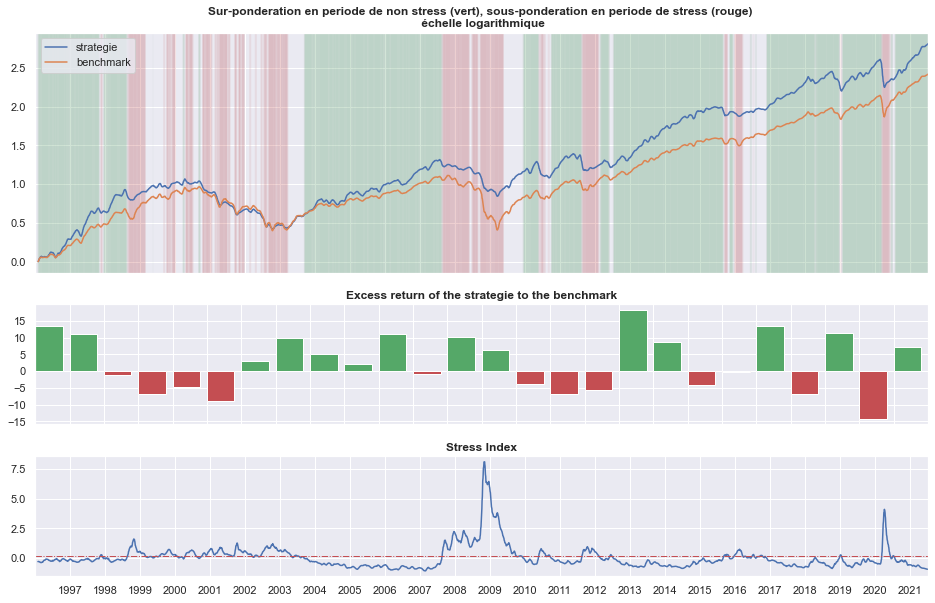

In [603]:
### Stratégie de base
tax = 0.0012

df_stress = pd.DataFrame(index=data.index)
df_stress['stress'] = data.Stress
# Premiere pente
df_stress['dx100'] = df_stress.stress.rolling(200).apply(lambda x: (x[-1] - x[0]) / len(x))
# Deuxieme pente
df_stress['ddx100'] = df_stress.dx100.rolling(100).apply(lambda x: (x[-1] - x[0]) / len(x))
# 1 si premiere pente positive, 0 sinon
df_stress['signal_dx'] = (df_stress.dx100 > 0).astype(int)

window_mean = 21
for idx in tqdm(df_stress.index):
    iloc = df_stress.index.get_loc(idx)
    
    # 1 si moyenne des 15 derniers jours > 0.2
    if (df_stress.stress.iloc[iloc - window_mean:iloc].mean() > 0.2):
        df_stress.at[idx, 'signal_stress'] = 1
        
    # -1 si moyenne des 15 derniers jours < 0
    elif (df_stress.stress.iloc[iloc - window_mean:iloc].mean() < -0):
        df_stress.at[idx, 'signal_stress'] = -1
        
    else:
        df_stress.at[idx, 'signal_stress'] = 0
    
    # signal final: stress > 0.2, et pente positive => 1
    if (df_stress.signal_stress.loc[idx] == 1) & (df_stress.signal_dx.loc[idx] == 1):
        df_stress.at[idx, 'signal'] = 1
        
    elif (df_stress.signal_stress.loc[idx] == -1):
        df_stress.at[idx, 'signal'] = -1
        
    else:
        df_stress.at[idx, 'signal'] = 0

        
# 50% du return de l'indice quand Stress, 150% quand Non Stress, et 100% sinon
df_stress['weight'] = df_stress.signal.replace({0: 1, 1: 0.5, -1: 1.5})

df_stress['t_cost'] = (df_stress.signal.diff().fillna(0) != 0).astype(int).shift(1) * tax
df_stress['strategie'] = df_stress.weight * data.SP500.pct_change().shift(1) - df_stress.t_cost
df_stress['perf'] = (df_stress.strategie + 1).cumprod()

perf_bench = (1 + data.SP500.pct_change()).cumprod()
perf_pred = df_stress.perf

year_group_bench = perf_bench.resample('Y')
year_group_pred = perf_pred.resample('Y')

# Annual Alpha %
annual_returns_bench = (year_group_bench.last() - year_group_bench.first()) / year_group_bench.first()
annual_returns_pred = (year_group_pred.last() - year_group_pred.first()) / year_group_pred.first()
annual_diff = (annual_returns_pred - annual_returns_bench) * 100
annual_diff = annual_diff.reindex(df_stress.index, method='bfill')
df_annual_diff = pd.DataFrame(index=annual_diff.index, columns=['year', 'alpha'])
df_annual_diff['year'] = df_annual_diff.index.year
df_annual_diff['year'] = df_annual_diff.year.apply(str)
df_annual_diff['alpha'] = annual_diff.values
df_annual_diff['sign'] = np.sign(df_annual_diff.alpha)

# Plot
locator = dates.YearLocator(base=1, day=1, month=1)
formatter = dates.ConciseDateFormatter(locator)

fig, axs = plt.subplots(3, 1, figsize=(16,10), gridspec_kw={'height_ratios': [2, 1, 1]}, sharex=False)

sns.lineplot(ax=axs[0], data=np.log(df_stress.perf.rolling(20).mean()), label='strategie')
sns.lineplot(ax=axs[0], data=np.log((1 + data.SP500.pct_change()).cumprod().rolling(20).mean()), label='benchmark')
for idx in tqdm(df_stress.index):
    iloc = df_stress.index.get_loc(idx)
    if (df_stress.signal.loc[idx] == 1):
        axs[0].axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='r')
    elif (df_stress.signal.loc[idx] == -1):
        axs[0].axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='g')
        
axs[0].set_title('Sur-ponderation en periode de non stress (vert), sous-ponderation en periode de stress (rouge) \n échelle logarithmique', fontsize=12, fontweight='bold')   
axs[0].set_xlabel(None)
axs[0].set_ylabel(None)
axs[0].set_xlim(df_stress.index[0], df_stress.index[-1])
axs[0].xaxis.set_major_locator(locator)
axs[0].get_xaxis().set_ticklabels([])
axs[0].legend(loc='upper left')

axs[1].bar(x=df_annual_diff.year, height=df_annual_diff.alpha, 
           color=df_annual_diff.sign.replace({-1:'r', 1:'g'}), align='edge')
axs[1].locator_params(nbins=8, axis='y')
axs[1].set_xlim(0.0, 26)
axs[1].get_xaxis().set_ticklabels([])
axs[1].set_title('Excess return of the strategie to the benchmark', fontweight='bold', fontsize=12)

sns.lineplot(ax=axs[2], data=df_stress.stress.rolling(20).mean())
axs[2].axhline(y=0.2, linestyle='-.', c='r', lw=1)
axs[2].set_title('Stress Index', fontsize=12, fontweight='bold') 
axs[2].set_xlim(df_stress.index[0], df_stress.index[-1])
axs[2].set_xlabel(None)
axs[2].set_ylabel(None)
axs[2].xaxis.set_major_locator(locator)
axs[2].xaxis.set_major_formatter(formatter)
#axs[2].get_xaxis().set_ticklabels([])

plt.show()

100%|██████████| 6548/6548 [00:03<00:00, 1747.03it/s]


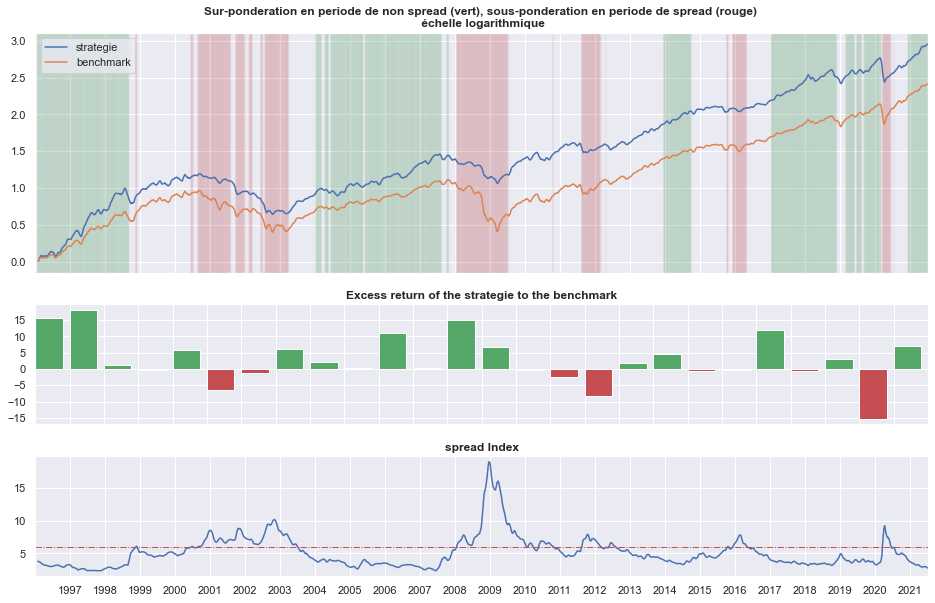

In [601]:
### Stratégie de base

df_spread = pd.DataFrame(index=data.index)
df_spread['spread'] = data.Spread
# Premiere pente
df_spread['dx100'] = df_spread.spread.rolling(200).apply(lambda x: (x[-1] - x[0]) / len(x))
# Deuxieme pente
df_spread['ddx100'] = df_spread.dx100.rolling(100).apply(lambda x: (x[-1] - x[0]) / len(x))
# 1 si premiere pente positive, 0 sinon
df_spread['signal_dx'] = (df_spread.dx100 > 0).astype(int)

for idx in df_spread.index:
    iloc = df_spread.index.get_loc(idx)
    
    # 1 si moyenne des 15 derniers jours > 6
    if (df_spread.spread.iloc[iloc - 15:iloc].mean() > 6):
        df_spread.at[idx, 'signal_spread'] = 1
    # -1 si moyenne des 15 derniers jours < 0
    elif (df_spread.spread.iloc[iloc - 15:iloc].mean() < 4):
        df_spread.at[idx, 'signal_spread'] = -1
    else:
        df_spread.at[idx, 'signal_spread'] = 0
    
    # signal final: spread > 0.2, et pente positive => 1
    if (df_spread.signal_spread.loc[idx] == 1) & (df_spread.signal_dx.loc[idx] == 1):
        df_spread.at[idx, 'signal'] = 1
    elif (df_spread.signal_spread.loc[idx] == -1):
        df_spread.at[idx, 'signal'] = -1
    else:
        df_spread.at[idx, 'signal'] = 0

# 50% du return de l'indice quand spread > 6, 150% quand spread < 4, et 100% sinon
df_spread['weight'] = df_spread.signal.replace({0: 1, 1: 0.5, -1: 1.5})

df_spread['t_cost'] = (df_spread.signal.diff().fillna(0) != 0).astype(int).shift(1) * tax
df_spread['strategie'] = df_spread.weight * data.SP500.pct_change().shift(1) - df_spread.t_cost
df_spread['perf'] = (df_spread.strategie + 1).cumprod()


perf_bench = (1 + data.SP500.pct_change()).cumprod()
perf_pred = df_spread.perf

year_group_bench = perf_bench.resample('Y')
year_group_pred = perf_pred.resample('Y')

# Annual Alpha %
annual_returns_bench = (year_group_bench.last() - year_group_bench.first()) / year_group_bench.first()
annual_returns_pred = (year_group_pred.last() - year_group_pred.first()) / year_group_pred.first()
annual_diff = (annual_returns_pred - annual_returns_bench) * 100
annual_diff = annual_diff.reindex(df_spread.index, method='bfill')
df_annual_diff = pd.DataFrame(index=annual_diff.index, columns=['year', 'alpha'])
df_annual_diff['year'] = df_annual_diff.index.year
df_annual_diff['year'] = df_annual_diff.year.apply(str)
df_annual_diff['alpha'] = annual_diff.values
df_annual_diff['sign'] = np.sign(df_annual_diff.alpha)

# Plot
locator = dates.YearLocator(base=1, day=1, month=1)
formatter = dates.ConciseDateFormatter(locator)

fig, axs = plt.subplots(3, 1, figsize=(16,10), gridspec_kw={'height_ratios': [2, 1, 1]}, sharex=False)

sns.lineplot(ax=axs[0], data=np.log(df_spread.perf.rolling(20).mean()), label='strategie')
sns.lineplot(ax=axs[0], data=np.log((1 + data.SP500.pct_change()).cumprod().rolling(20).mean()), label='benchmark')
for idx in tqdm(df_spread.index):
    iloc = df_spread.index.get_loc(idx)
    if (df_spread.signal.loc[idx] == 1):
        axs[0].axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='r')
    elif (df_spread.signal.loc[idx] == -1):
        axs[0].axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='g')
        
axs[0].set_title('Sur-ponderation en periode de non spread (vert), sous-ponderation en periode de spread (rouge) \n échelle logarithmique', fontsize=12, fontweight='bold')   
axs[0].set_xlabel(None)
axs[0].set_ylabel(None)
axs[0].set_xlim(df_spread.index[0], df_spread.index[-1])
axs[0].xaxis.set_major_locator(locator)
axs[0].get_xaxis().set_ticklabels([])
axs[0].legend(loc='upper left')

axs[1].bar(x=df_annual_diff.year, height=df_annual_diff.alpha, 
           color=df_annual_diff.sign.replace({-1:'r', 1:'g'}), align='edge')
axs[1].locator_params(nbins=8, axis='y')
axs[1].set_xlim(0.0, 26)
axs[1].get_xaxis().set_ticklabels([])
axs[1].set_title('Excess return of the strategie to the benchmark', fontweight='bold', fontsize=12)

sns.lineplot(ax=axs[2], data=df_spread.spread.rolling(20).mean())
axs[2].axhline(y=6, linestyle='-.', c='r', lw=1)
axs[2].set_title('spread Index', fontsize=12, fontweight='bold') 
axs[2].set_xlim(df_spread.index[0], df_spread.index[-1])
axs[2].set_xlabel(None)
axs[2].set_ylabel(None)
axs[2].xaxis.set_major_locator(locator)
axs[2].xaxis.set_major_formatter(formatter)
#axs[2].get_xaxis().set_ticklabels([])

plt.show()

In [578]:
df_risque = pd.DataFrame().reindex(df_spread.index)
df_risque['stress'] = df_stress.stress
df_risque['spread'] = df_spread.spread

In [579]:
for idx in tqdm(df_risque.index):
    if (df_risque.at[idx, 'stress'] < 0.2) & (df_risque.at[idx, 'spread'] < 6):
        df_risque.at[idx, 'signal'] = -1
    if (df_risque.at[idx, 'stress'] > 0.2) & (df_risque.at[idx, 'spread'] > 6):
        df_risque.at[idx, 'signal'] = 1
    if (df_risque.at[idx, 'stress'] < 0.2) & (df_risque.at[idx, 'spread'] > 6):
        df_risque.at[idx, 'signal'] = 0.5
    if (df_risque.at[idx, 'stress'] > 0.2) & (df_risque.at[idx, 'spread'] < 6):
        df_risque.at[idx, 'signal'] = -0.5

100%|██████████| 6548/6548 [00:00<00:00, 23288.96it/s]


100%|██████████| 6548/6548 [00:11<00:00, 574.47it/s] 


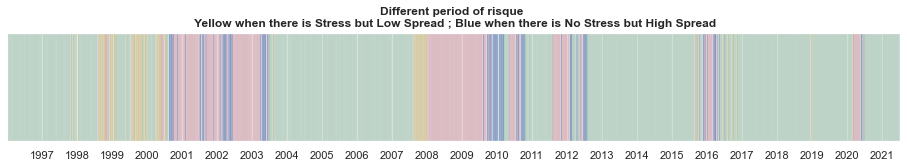

In [595]:
fig, ax = plt.subplots(figsize=(16, 2))
locator = dates.YearLocator(base=1, day=1, month=1)
formatter = dates.ConciseDateFormatter(locator)

for idx in tqdm(df_risque.index):
    if (df_risque.signal.loc[idx] == -1):
        ax.axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='g', label='No Stress and Low Spread')
    if (df_risque.signal.loc[idx] == 1):
        ax.axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='r', label='Stress and High Spread')
    if (df_risque.signal.loc[idx] == -0.5):
        ax.axvline(x=idx, lw=1, alpha=0.1, zorder=1, c='y', label='Stress but Low Spread')
    if (df_risque.signal.loc[idx] == 0.5):
        ax.axvline(x=idx, lw=1, alpha=0.1, zorder=1, c='b', label='No Stress but High Spread')
        
        
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(df_risque.index[0], df_risque.index[-1])
ax.get_yaxis().set_visible(False)
plt.title('Different period of risque \n Yellow when there is Stress but Low Spread ; Blue when there is No Stress but High Spread', fontweight='bold')
plt.show()

100%|██████████| 6548/6548 [00:08<00:00, 803.22it/s] 


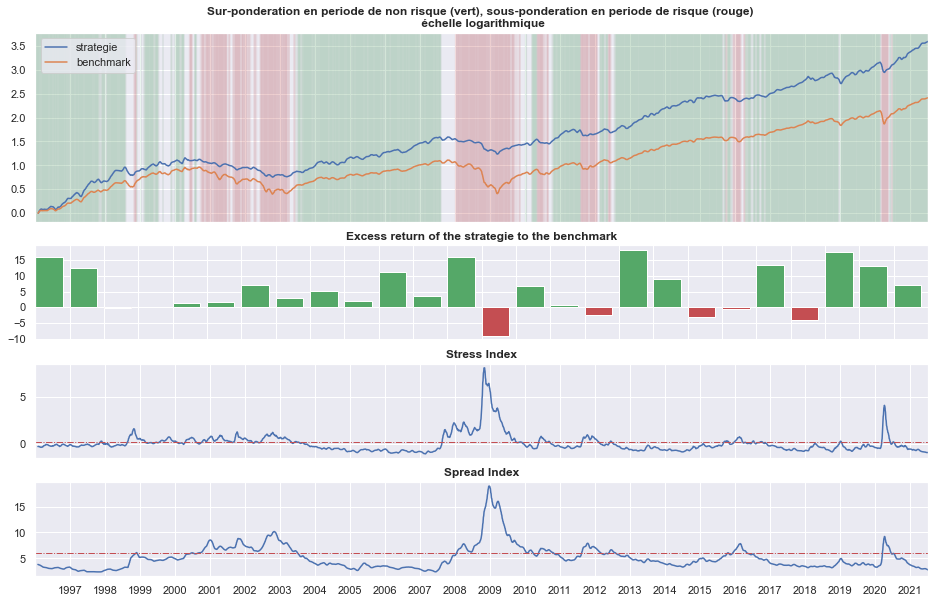

In [602]:
# 50% du return de l'indice quand risque > 6, 150% quand risque < 4, et 100% sinon
df_risque['weight'] = df_risque.signal.replace({0.5: 1, -0.5: 1, 1: 0.5, -1: 1.5})

df_risque['t_cost'] = (df_risque.signal.diff().fillna(0) != 0).astype(int).shift(1) * tax
df_risque['strategie'] = df_risque.weight * data.SP500.pct_change().shift(1) - df_risque.t_cost
df_risque['perf'] = (df_risque.strategie + 1).cumprod()


perf_bench = (1 + data.SP500.pct_change()).cumprod()
perf_pred = df_risque.perf

year_group_bench = perf_bench.resample('Y')
year_group_pred = perf_pred.resample('Y')

# Annual Alpha %
annual_returns_bench = (year_group_bench.last() - year_group_bench.first()) / year_group_bench.first()
annual_returns_pred = (year_group_pred.last() - year_group_pred.first()) / year_group_pred.first()
annual_diff = (annual_returns_pred - annual_returns_bench) * 100
annual_diff = annual_diff.reindex(df_risque.index, method='bfill')
df_annual_diff = pd.DataFrame(index=annual_diff.index, columns=['year', 'alpha'])
df_annual_diff['year'] = df_annual_diff.index.year
df_annual_diff['year'] = df_annual_diff.year.apply(str)
df_annual_diff['alpha'] = annual_diff.values
df_annual_diff['sign'] = np.sign(df_annual_diff.alpha)

# Plot
locator = dates.YearLocator(base=1, day=1, month=1)
formatter = dates.ConciseDateFormatter(locator)

fig, axs = plt.subplots(4, 1, figsize=(16,10), gridspec_kw={'height_ratios': [2, 1, 1, 1]}, sharex=False)

sns.lineplot(ax=axs[0], data=np.log(df_risque.perf.rolling(20).mean()), label='strategie')
sns.lineplot(ax=axs[0], data=np.log((1 + data.SP500.pct_change()).cumprod().rolling(20).mean()), label='benchmark')
for idx in tqdm(df_risque.index):
    iloc = df_risque.index.get_loc(idx)
    if (df_risque.signal.loc[idx] == 1):
        axs[0].axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='r')
    elif (df_risque.signal.loc[idx] == -1):
        axs[0].axvline(x=idx, lw=0.4, alpha=0.1, zorder=1, c='g')
        
axs[0].set_title('Sur-ponderation en periode de non risque (vert), sous-ponderation en periode de risque (rouge) \n échelle logarithmique', fontsize=12, fontweight='bold')   
axs[0].set_xlabel(None)
axs[0].set_ylabel(None)
axs[0].set_xlim(df_risque.index[0], df_risque.index[-1])
axs[0].xaxis.set_major_locator(locator)
axs[0].get_xaxis().set_ticklabels([])
axs[0].legend(loc='upper left')

axs[1].bar(x=df_annual_diff.year, height=df_annual_diff.alpha, 
           color=df_annual_diff.sign.replace({-1:'r', 1:'g'}), align='edge')
axs[1].locator_params(nbins=8, axis='y')
axs[1].set_xlim(0.0, 26)
axs[1].get_xaxis().set_ticklabels([])
axs[1].set_title('Excess return of the strategie to the benchmark', fontweight='bold', fontsize=12)

sns.lineplot(ax=axs[2], data=df_risque.stress.rolling(20).mean())
axs[2].axhline(y=0.2, linestyle='-.', c='r', lw=1)
axs[2].set_title('Stress Index', fontsize=12, fontweight='bold') 
axs[2].set_xlim(df_risque.index[0], df_risque.index[-1])
axs[2].set_xlabel(None)
axs[2].set_ylabel(None)
axs[2].xaxis.set_major_locator(locator)
axs[2].get_xaxis().set_ticklabels([])
#axs[2].xaxis.set_major_formatter(formatter)

sns.lineplot(ax=axs[3], data=df_risque.spread.rolling(20).mean())
axs[3].axhline(y=6, linestyle='-.', c='r', lw=1)
axs[3].set_title('Spread Index', fontsize=12, fontweight='bold') 
axs[3].set_xlim(df_risque.index[0], df_risque.index[-1])
axs[3].set_xlabel(None)
axs[3].set_ylabel(None)
axs[3].xaxis.set_major_locator(locator)
axs[3].xaxis.set_major_formatter(formatter)

plt.show()